# Problem Definition

Use historical boxscores to predict an NBA player's Blocks Per Second (BPS) in a single game. In conjunction with the predicted NBA player's Seconds Played (SP) will be used to predict the total blocks of a player in a single game.

### Usage

- The final blocks projection will be used along other stat projections to predict a player's Daily Fantasy Sports (DFS) Fantasy Score. 
- The projection will also be used to bet on vegas lines.

# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/.virtualenvs/nbavenv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Factor Determination
Determine the factors that influence a player's Blocks Per Second (BPS).

- Historical BPS
    - Season averages
    - Recent performances
    - Home vs. Away
    - Start vs. Bench
    - Rest


- Position


- Defense
    - Opponent BPS Allowed
        - Starters vs. Bench Players
        - By position
    - Vegas implied total points

# Data Analysis
Summarize the characteristics of the dataset.

First, I will pull the boxscore data and drop the unessesary rows.

In [2]:
query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

pd.set_option('display.max_columns', None)
display(boxscores.head())

/Users/brandonshimiaie/Projects/sqlite/db/nba.db
2.6.0


,PLAYERID,TEAM,GAMEID,OPP_TEAM,COMMENT,START,SECONDSPLAYED,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PCT_AST_2PM,PCT_AST_3PM,OREB,OREB_PCT,DREB,DREB_PCT,AST,AST_PCT,AST_RATIO,STL,BLK,TOV,PF,PLUSMINUS,USG_PCT,PACE,ID_x,SEASON,DATE,HTM,VTM,W,ID_y,NAME,POSITION,SCHOOL,COUNTRY,HEIGHT,WEIGHT,DRAFTYEAR,DRAFTROUND,DRAFTNUMBER,BIRTHDATE
0,203906,ORL,0021400001,NOP,,0,179,4,2,2,0,0,0,2,0,0,2,4,0.500,0.0,0,0.000,1.0,0.333,0,0.000,0.0,0,0,0,1,4,0.300,112.63,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,203906,Devyn Marble,Forward,Iowa,USA,78,200,2014,2,56,1992-09-21
1,2584,ORL,0021400001,NOP,,0,247,0,0,1,0,0,0,0,0,0,0,0,0.000,0.0,1,0.250,1.0,0.100,0,0.000,0.0,0,0,0,0,-3,0.100,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,2584,Willie Green,Guard,Detroit Mercy,USA,75,205,2003,2,41,1981-07-28
2,202690,NOP,0021400001,ORL,,0,1068,2,0,6,0,3,2,2,0,0,0,0,0.000,0.0,0,0.000,0.0,0.000,2,0.133,22.2,1,0,0,3,3,0.146,98.43,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202690,Jimmer Fredette,Guard,Brigham Young,USA,74,195,2011,1,10,1989-02-25
3,202699,ORL,0021400001,NOP,,1,2192,25,9,18,1,2,6,6,6,5,8,16,0.625,1.0,2,0.048,6.0,0.111,0,0.000,0.0,1,0,4,2,-4,0.289,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202699,Tobias Harris,Forward,Tennessee,USA,80,226,2011,1,19,1992-07-15
4,201950,NOP,0021400001,ORL,,1,1622,8,4,11,0,3,0,0,2,2,2,6,0.250,0.0,0,0.000,2.0,0.067,4,0.190,23.5,3,1,2,2,9,0.188,94.99,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,201950,Jrue Holiday,Guard,UCLA,USA,75,205,2009,1,17,1990-06-12


I need to determine the type of each column, as well as the proportion of missing data.

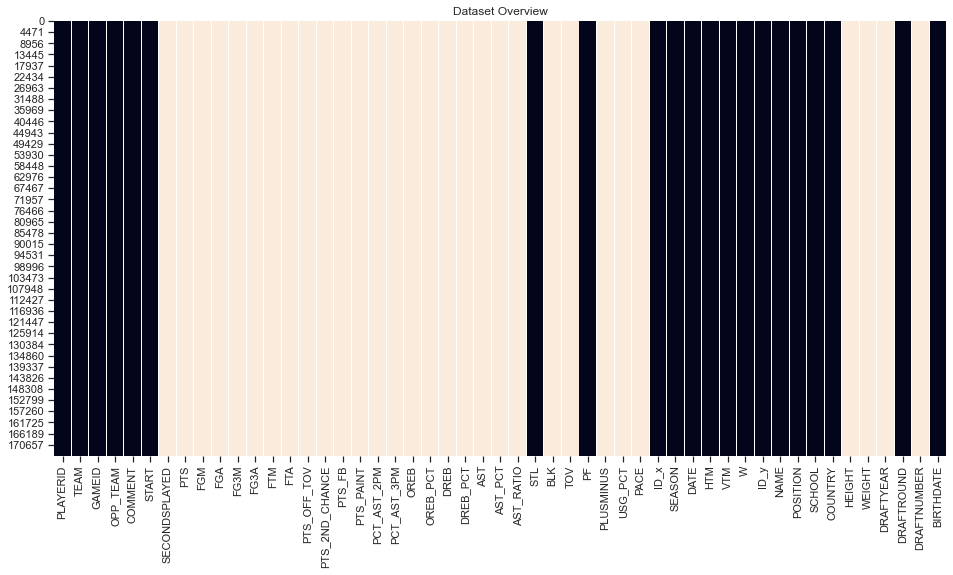

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [3]:
helpers = Helpers()

plt.rcParams["figure.figsize"] = (16, 8)
helpers.visualize_dataframe(boxscores)

Great, there is no missing data.

Next I will create the column of our dependant variable, $BPS$.

In [4]:
y = 'Y'
boxscores[y] = boxscores['BLK']/boxscores['SECONDSPLAYED']

Let's take a look at the distribution of values of our dependant variable. I will use a histogram to to visualize the probability density distribution of the outcomes of $Y$, and a box plot to graph data groups and outliers.

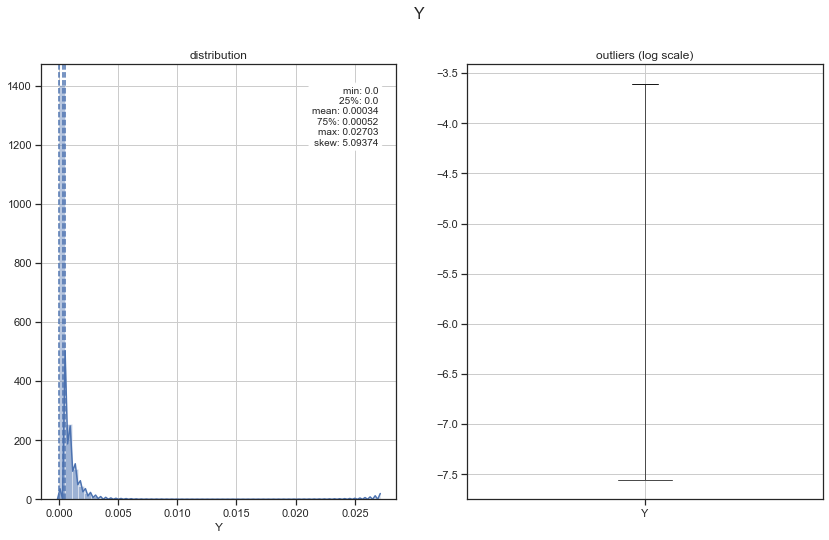

In [5]:
helpers.visualize_variable_distribution(boxscores, y, figsize=(14, 8))

Yikes.

There is clearly an abundance of outliers on the right side of the distribution.

My first guess of the cause of the plethora of outliers is that those outliers come from boxscores in which the player played very few seconds. For example, if a player played for 6 seconds, and blocked 1 shot, his $BPS$ would be 0.167. That would be an outlier in our distribtion.

Below shows the $BPS$ distribution across different playing times.

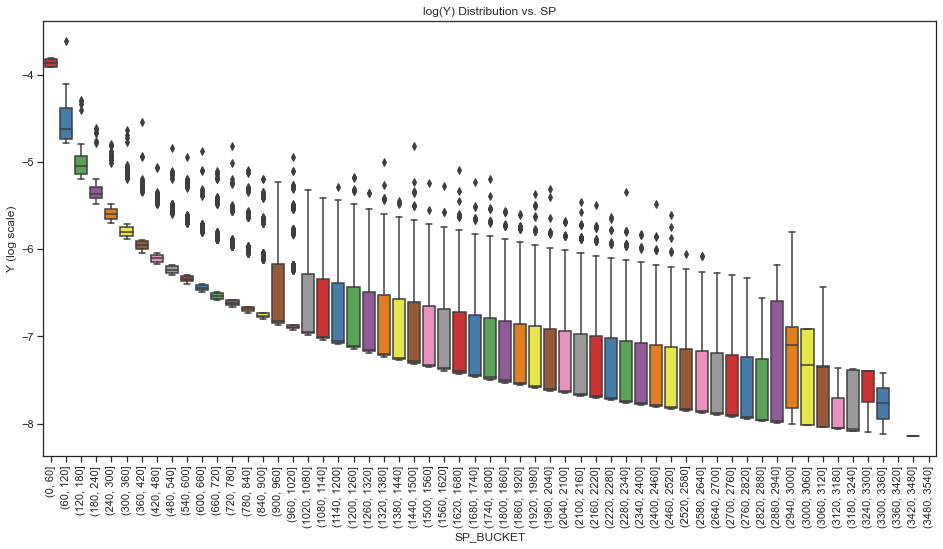

In [6]:
sp_max = boxscores['SECONDSPLAYED'].max()
max_bucket = int(60 * round(float(sp_max)/60))
buckets = [i for i in range(0, max_bucket, 60)]

temp = boxscores[[y, 'SECONDSPLAYED']]
temp['Y (log scale)'] = temp[y].apply(lambda x: np.log(x) if x > 0 else np.nan)
temp['SP_BUCKET'] = pd.cut(temp['SECONDSPLAYED'], buckets)

ax = sns.boxplot(x="SP_BUCKET", y="Y (log scale)", data=temp, palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('log(Y) Distribution vs. SP')
plt.show()
plt.close()

It seems as though the outliers are coming from the (0, 60] seconds played bucket. Let's remove those values from our set of outcomes, and replot the distributions.

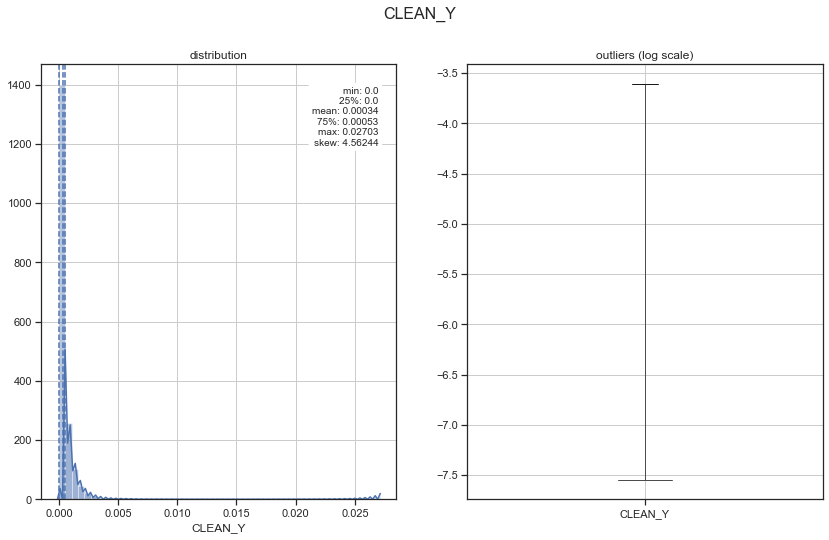

In [7]:
sp_threshold = 60

clean_y = 'CLEAN_Y'
boxscores[clean_y] = boxscores[y]
boxscores.loc[boxscores['SECONDSPLAYED'] <= sp_threshold, clean_y] = np.nan
helpers.visualize_variable_distribution(boxscores, clean_y, figsize=(14, 8))

This distribution looks better. We have far less positive outliers.

However, the distribution is still very skewed right and contains many outliers much higher than our mean.

Let's try looking at the distribtion of log outcomes.

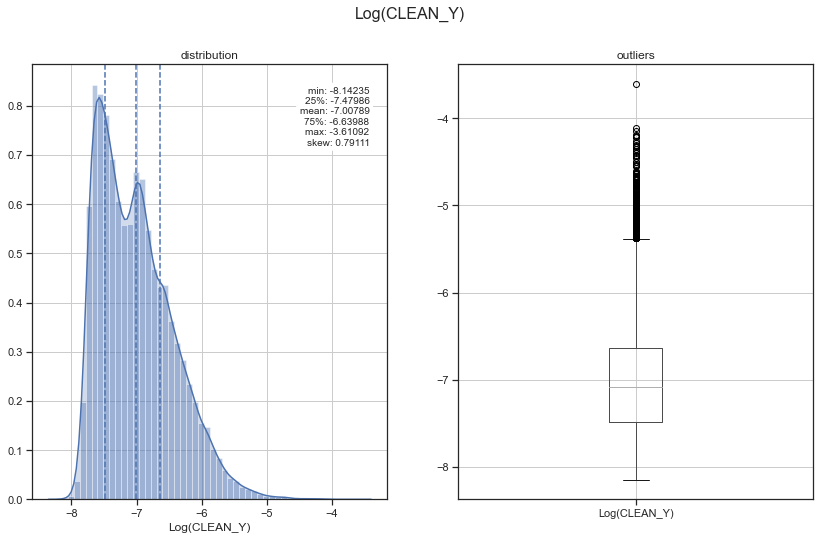

In [8]:
boxscores['Log(CLEAN_Y)'] = np.log(boxscores[clean_y])
boxscores['Log(CLEAN_Y)'] = boxscores['Log(CLEAN_Y)'].replace(-np.inf, np.nan)

helpers.visualize_variable_distribution(boxscores, 'Log(CLEAN_Y)', log_boxplot=False, figsize=(14, 8))

In [9]:
stat, p = shapiro(boxscores['Log(CLEAN_Y)'].dropna())
print(stat, p)

0.9480825066566467 0.0


Much better.

The distribution now contains a roughly equal amount of outliers on the left and right side, is less skewed, and is statistically normal

# Feature Engineering
Create new features from raw data using domain knowlege.

In [10]:
regressors = []
categorical_regressors = []

### Historical BPS
First, I will create features that represent a player's historical $BPS$.

I will start by calculating the running $BPS$ of a player in a season.

In [11]:
feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y'
)

regressors.append('AVG_Y')

Next, I will calculate the average $BPS$ of a player in the previous games against the same opposing team in the same season.

In [12]:
boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'OPP_TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_OPP_TEAM'
)

regressors.append('AVG_Y_OPP_TEAM')

Do more recent block performances within a season matter more than previous ones?

To answer this, first I will calculate the Autocorrelation between a player's $BPS$ and his previous $BPS$ values:

$$ ACF(X_{0}, X_{i}) $$ <br>

Then, I will calculate the Partial Autocorrelation between between a player's $BPS$ and his previous $BPS$ values, using the lags in between as covariates:

$$ PACF(X_{0}, X_{i}  |  \{X_{j}\}_{0<j<i}) $$ <br>

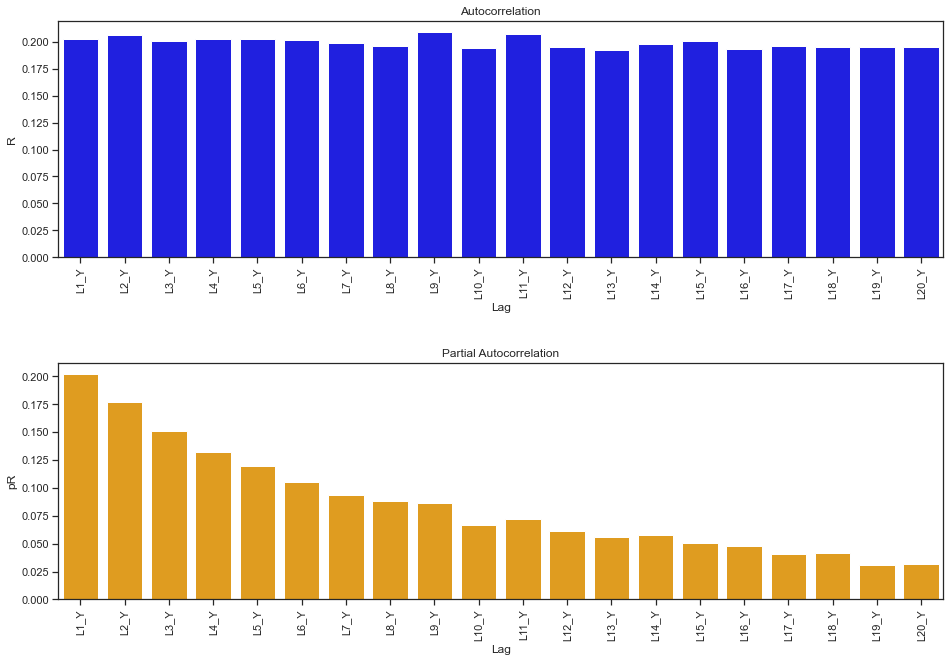

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

x_ticks = []
corrs = []
p_corrs = []
for i in range(1, 21):
    x = 'L{}_{}'.format(str(i), y)

    boxscores = feature_creation.lag(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=clean_y, new_col_name=x, n_shift=i
    )
    
    corr = boxscores[clean_y].corr(boxscores[x])
    p_corr = pg.partial_corr(data=boxscores, x=x, y=clean_y, covar=x_ticks)
    
    corrs.append(corr)
    p_corrs.append(p_corr['r'][0])
    x_ticks.append(x)
    
corr_df = pd.DataFrame({'R': corrs, 'pR': p_corrs, 'Lag': x_ticks})

sns.barplot(x='Lag', y='R', data=corr_df, color='blue', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].title.set_text('Autocorrelation')

sns.barplot(x='Lag', y='pR', data=corr_df, color='orange', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].title.set_text('Partial Autocorrelation')

fig.tight_layout(pad=3.0)
plt.show()
plt.close()

While the Autocorrelaton of each between $BPS$ and each $BPS_{i}$ is similar, the Partial Autocorrelations exponentially decrease. This tells us that each $X_{i}$ tells us less new information than the preceding lag does. This is a reason for us to add the first lags to our list of regressors. It also makes the case that an exponentially weighted mean of previous lags may be more predictive than a normal mean.

In [14]:
regressors.append('L1_Y')

boxscores = feature_creation.expanding_ewm(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name='EWM_Y', alpha=0.90
)

regressors.append('EWM_Y')

Next, I will calculate the partial correlation between $BPS$ and previous moveing averages of $BPS$, using a covariate of the AVG_$BPS$. The peak of this graph will tell us which MA provides the most new information on top of the average.

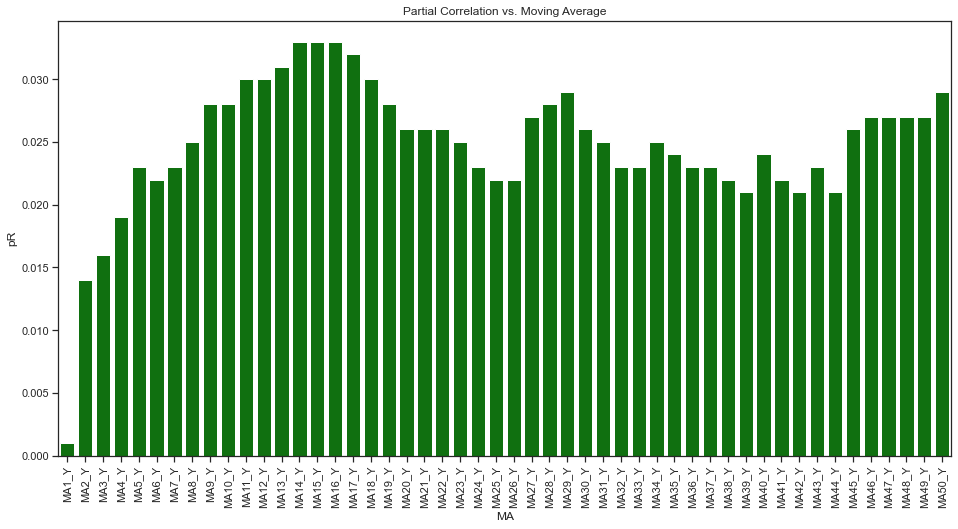

In [15]:
x_ticks = []
p_corrs = []
for i in range(1, 51):
    x = 'MA{}_{}'.format(str(i), y)

    boxscores = feature_creation.rolling_weighted_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name=x,
        weight_col_name='SECONDSPLAYED', n_rolling=i, min_periods=math.ceil(i/2)
    )
    
    p_corr = pg.partial_corr(data=boxscores, x=x, y=clean_y, covar=['AVG_Y'])
    
    x_ticks.append(x)
    p_corrs.append(p_corr['r'][0])
    
corr_df = pd.DataFrame({'pR': p_corrs, 'MA': x_ticks})
ax = sns.barplot(x='MA', y='pR', data=corr_df, color='green')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('Partial Correlation vs. Moving Average')
plt.show()
plt.close()

I will use MA5_$BPS$ and MA14_$BPS$.

In [16]:
regressors.append('MA5_Y')
regressors.append('MA14_Y')

Now I will determine if the dependant variable, $Y$, depends on various categorical variables in our data set.

First I will visualize the difference of the distributions and means of $Y$ when a player is playing at Home or Away.

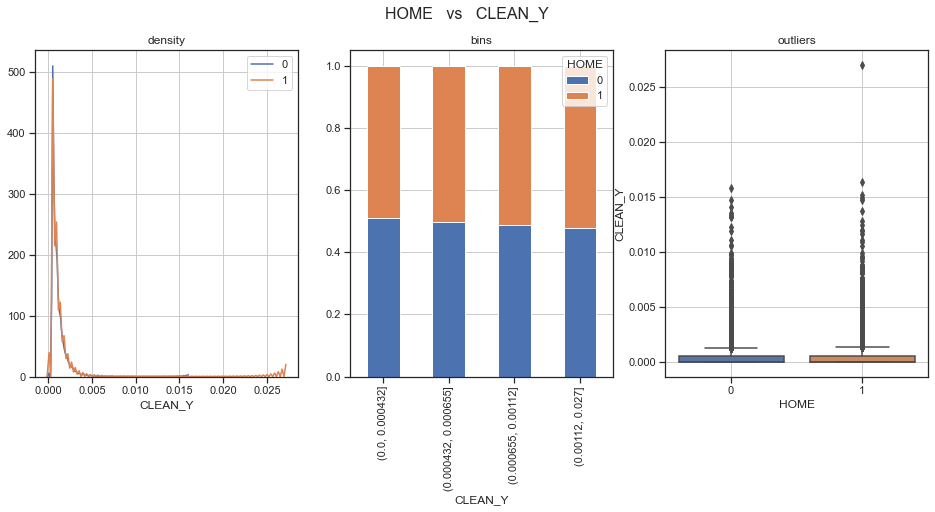

In [17]:
boxscores['HOME'] = 0
boxscores.loc[boxscores['TEAM'] == boxscores['HTM'], 'HOME'] = 1
helpers.visualize_categorical_x_vs_y(boxscores, 'HOME', clean_y)

There does not seem to be a relationship between the location a player plays at and his $BPS$.

Next I will determine if a player's $BPS$ depends on his status as a Starter.

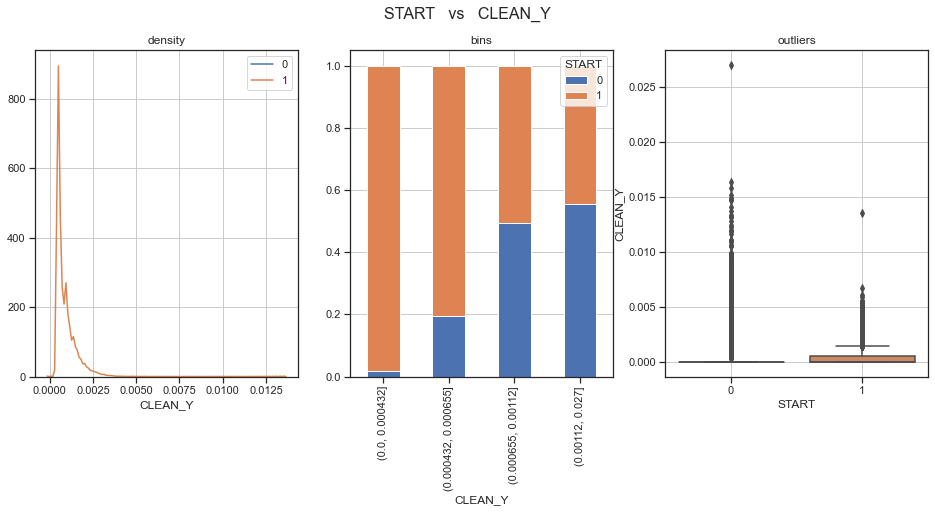

In [18]:
helpers.visualize_categorical_x_vs_y(boxscores, 'START', clean_y)

At a glance, it seems like there may be a slight relationship between starting status and $BPS$.

To confirm this hypothesis, I will investigate the percentage of (season, player) groups in the dataset exhibit a statistically significant difference between their mean $BPS$ when they start and are benched. To test significance, I will use a one-way ANOVA test.

In [19]:
num_valid_player_seasons = 0
significant_player_seasons = []
a = 0.01
for player_season, temp in boxscores.groupby(['SEASON', 'PLAYERID']):
    anova = pg.anova(dv=y, between='START', data=temp, detailed=False)
    p = anova['p-unc'].iloc[0]
    if p != '-':
        num_valid_player_seasons += 1
        if float(p) < a:
            significant_player_seasons.append(player_season)

print('Number of significant (season, player) combinations:', len(significant_player_seasons))
print('Percentage of significant (season, player) combinations:', len(significant_player_seasons)/num_valid_player_seasons)

Number of significant (season, player) combinations: 36
Percentage of significant (season, player) combinations: 0.020689655172413793


The percentage of (season, player) combinations that exibit a significant difference is 2.07%, almost twice our alpha of 1%. This is enough to add a categorical variable that identifies if a player is starting, 'START', to the list of regressors. I will also add the season average $BPS$ of a player in the role he is playing to our list of regressors. I will call this variable: $AVG\_Y\_R$.

In [20]:
regressors.append('START')
categorical_regressors.append('SART')

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_R'
)
regressors.append('AVG_Y_R')

Next, I will determine if the number of days a player rests is indicative of his $BPS$.

In [21]:
boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DATE', new_col_name='LAST_DATE'
)
boxscores['LAST_DATE'] = boxscores['LAST_DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)
boxscores['DATE'] = boxscores['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores['REST'] = boxscores[['DATE', 'LAST_DATE']].apply(
    lambda x: max(min((x[0] - x[1]).days, 5), 1) if not (isinstance(x[0], str) or isinstance(x[1], str)) else np.nan,
    axis=1
)

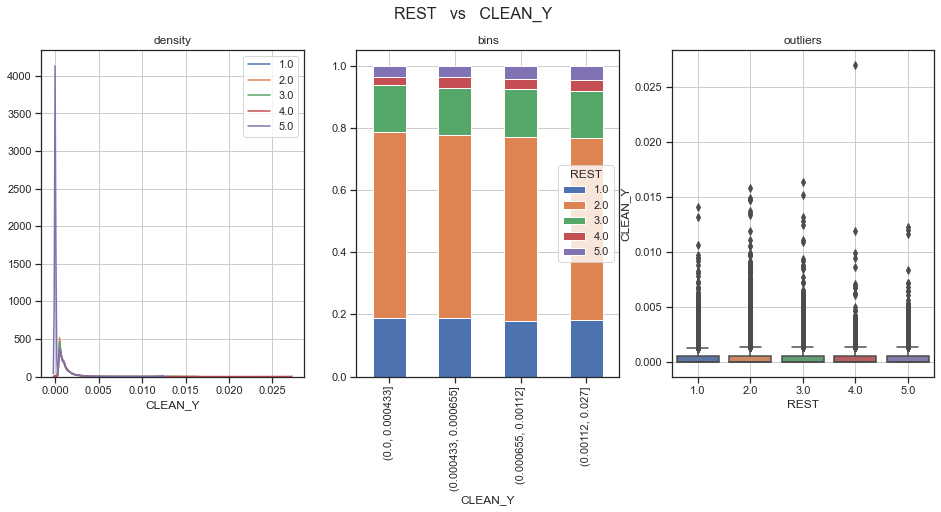

In [22]:
helpers.visualize_categorical_x_vs_y(boxscores, 'REST', clean_y)

No significant relationship.

### Position
Next, I will determine if a player's position is indicative of his $BPS$

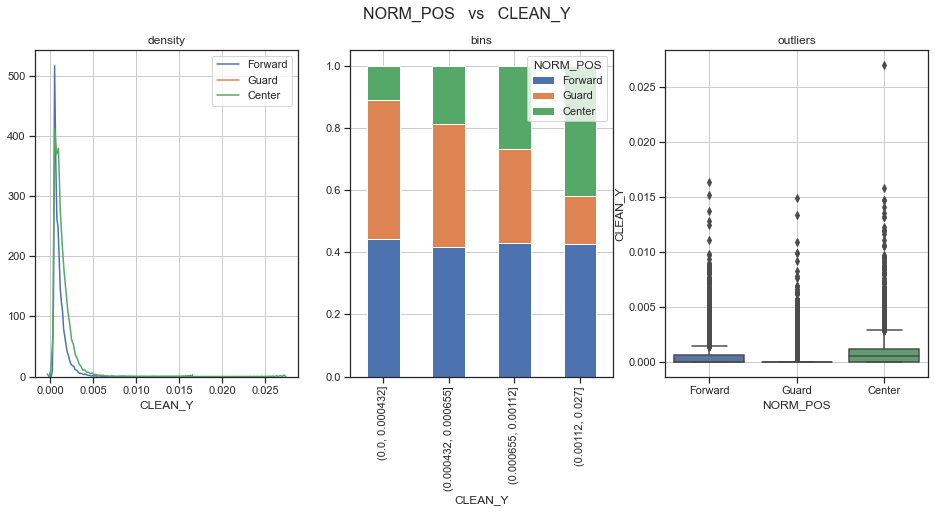

In [23]:
boxscores['NORM_POS'] = boxscores['POSITION'].apply(lambda x: x if '-' not in x else x.split('-')[0])

helpers.visualize_categorical_x_vs_y(boxscores, 'NORM_POS', clean_y)

In [24]:
boxscores['GUARD'] = 0
boxscores.loc[boxscores['NORM_POS'] == 'Guard', 'GUARD'] = 1

boxscores['FORWARD'] = 0
boxscores.loc[boxscores['NORM_POS'] == 'Forward', 'FORWARD'] = 1

boxscores['CENTER'] = 0
boxscores.loc[boxscores['NORM_POS'] == 'Center', 'CENTER'] = 1

regressors.append('GUARD')
regressors.append('FORWARD')
regressors.append('CENTER')

categorical_regressors.append('GUARD')
categorical_regressors.append('FORWARD')
categorical_regressors.append('CENTER')

### Defense
Next, I will create features based on the defense of the opposing team.

First, I will calculate the block defense of each team on a game-to-game basis. I will define three metrics to measure block defense:

$$TEAM\_Y\_DIFF\_ALLOWED =  TEAM\_Y\_ALLOWED - TEAM\_Y\_AVG$$

where $TEAM\_Y\_ALLOWED$ is the $BPS$ allowed to the opposing team and $TEAM\_Y\_AVG$ is the $BPS$ of that team throughout the season coming into the game.

In [25]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='BLK', new_col_name='AVG_BLK'
)
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='AVG_SP'
)

temp = boxscores.dropna(subset=['BLK', 'SECONDSPLAYED', 'AVG_BLK', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED': x['BLK'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG': x['AVG_BLK'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED'] - grouped_defensive_boxscores['TEAM_Y_AVG']

Next, I will visualize the defense of each team for each season in the dataset. I will also run a one-way ANOVA test to determine if the mean $TEAM\_Y\_DIFF\_ALLOWED$ differs among the teams in each season.

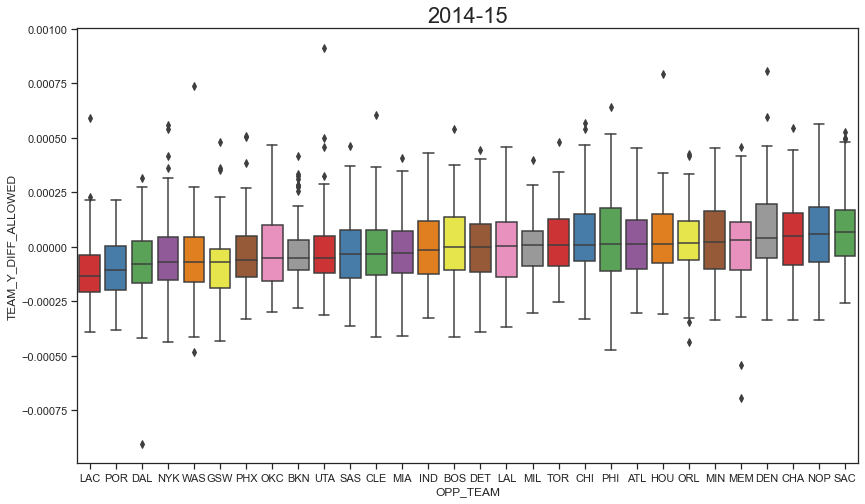

Team defenses are statistically siginficantly different


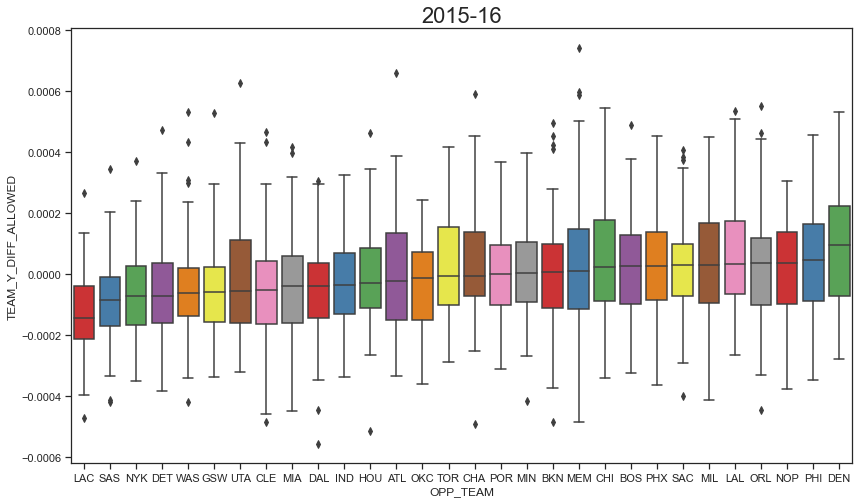

Team defenses are statistically siginficantly different


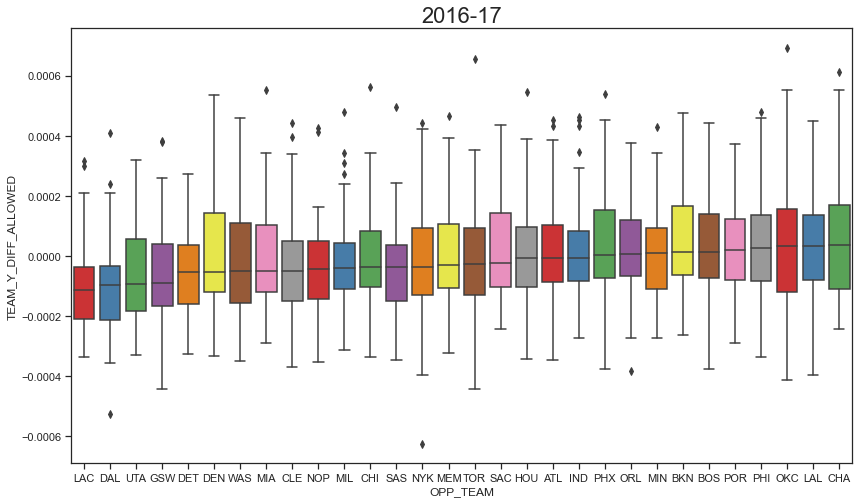

Team defenses are statistically siginficantly different


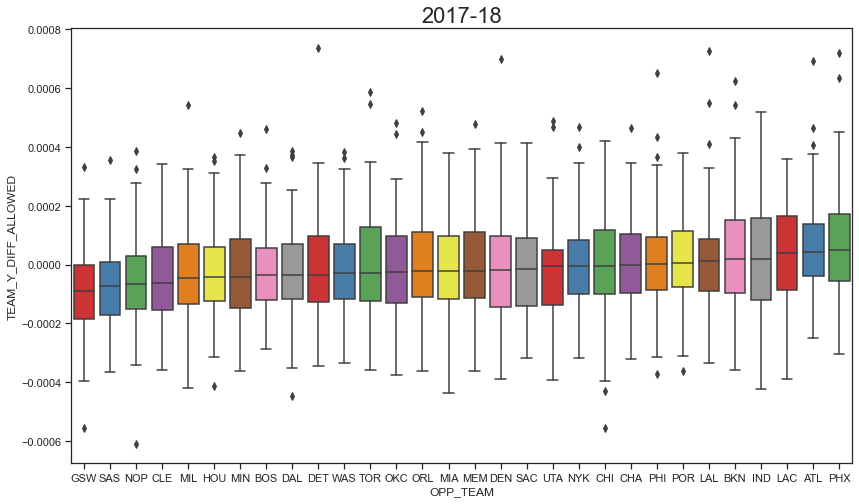

Team defenses are statistically siginficantly different


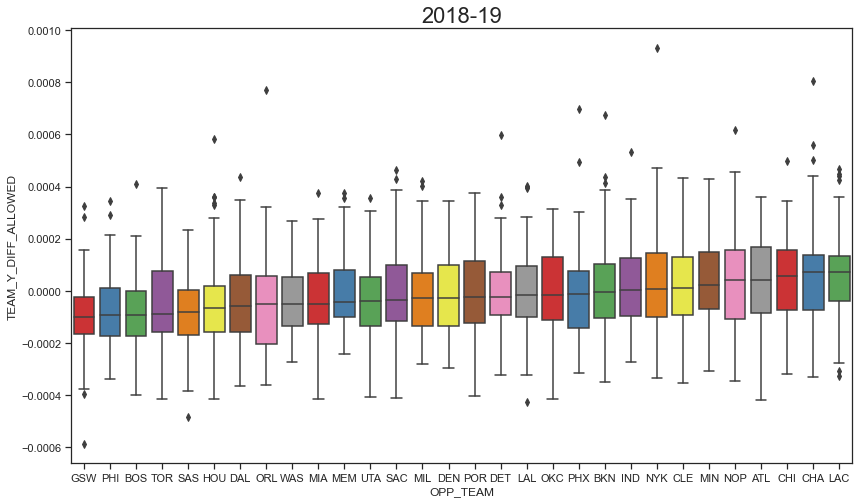

Team defenses are statistically siginficantly different


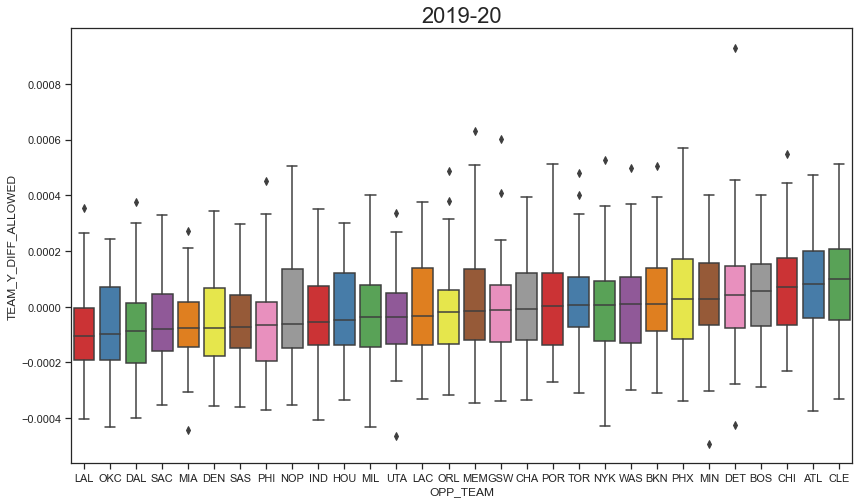

Team defenses are statistically siginficantly different


In [26]:
a = 0.01
for season, temp in grouped_defensive_boxscores.groupby(['SEASON']):
    plt.figure(figsize=(14, 8))
    plt.title(season,fontsize=22)
    opp_team_def = [
        (opp_team, temp2['TEAM_Y_DIFF_ALLOWED'].median()) for opp_team, temp2 in temp.groupby('OPP_TEAM')
    ]
    opp_team_def.sort(key = lambda x: x[1])
    opp_teams = [i[0] for i in opp_team_def]
    sns.boxplot(x="OPP_TEAM", y="TEAM_Y_DIFF_ALLOWED", data=temp, palette="Set1", order=opp_teams)
    
    plt.show()
    plt.close()
    
    anova = pg.anova(dv='TEAM_Y_DIFF_ALLOWED', between='OPP_TEAM', data=temp, detailed=True)
    p = anova['p-unc'].iloc[0]
    if p < a:
        print('Team defenses are statistically siginficantly different')
    else:
        print('Team defenses are not statistically siginficantly different')

Now, I will calculate the average block defense of the opposing team across all previous games in a season, $AVG\_TEAM\_Y\_DIFF\_ALLOWED$.

In [27]:
grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM'], col_name='TEAM_Y_DIFF_ALLOWED', new_col_name='AVG_TEAM_Y_DIFF_ALLOWED',
    order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM'], how='left')

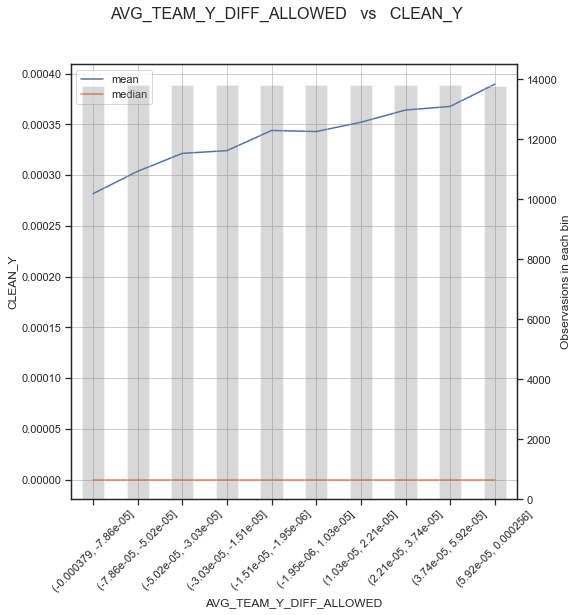

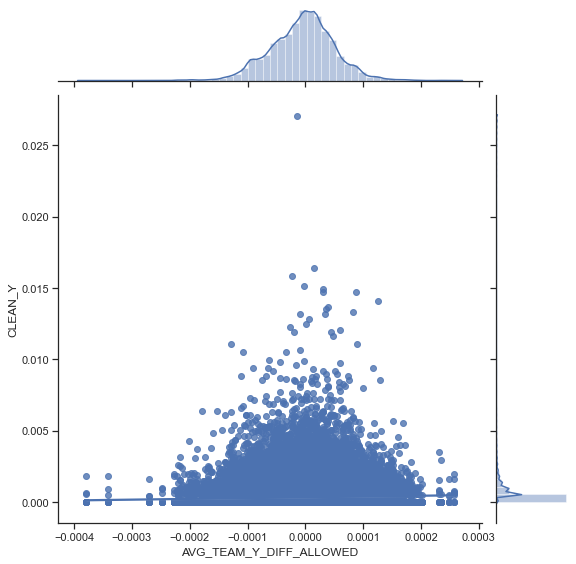

In [28]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED', clean_y, figsize=(8, 8))

In [29]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED')

The metrics above track the opposing team's block defense on all players. However, an opposing team's block defense may differ among starts and bench players, as each set will have a mostly different group of opposing players.

I will use the variable $TEAM\_Y\_DIFF\_ALLOWED\_P$ to quantify a team's block defense on opposing players by role (guard/forward/center).

In [30]:
boxscores['NORM_POS'] = boxscores['POSITION'].apply(lambda x: x if '-' not in x else x.split('-')[0])

temp = boxscores.dropna(subset=['BLK', 'SECONDSPLAYED', 'AVG_BLK', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'NORM_POS', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED_P': x['BLK'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG_P': x['AVG_BLK'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED_P'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED_P'] - grouped_defensive_boxscores['TEAM_Y_AVG_P']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM', 'NORM_POS'], col_name='TEAM_Y_DIFF_ALLOWED_P',
    new_col_name='AVG_TEAM_Y_DIFF_ALLOWED_P', order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM', 'NORM_POS'], how='left')

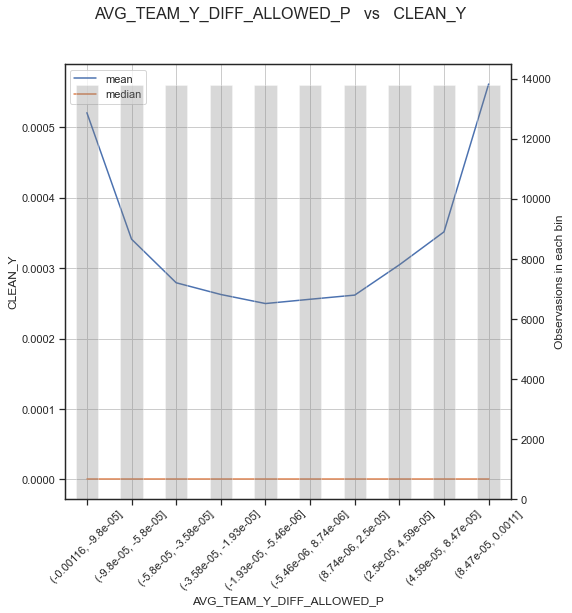

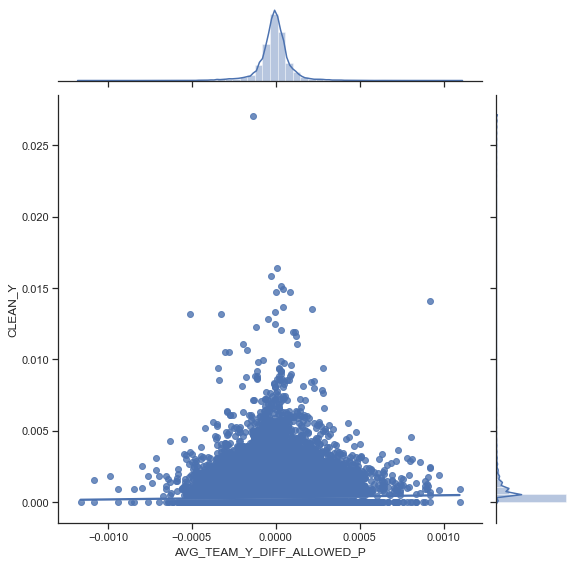

In [31]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED_P', clean_y, figsize=(8, 8))

In [32]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED_P')

I will also include the vegas implied game point total as a feature.

In [33]:
odds = query_data.query_odds_data()
odds['TOTAL'] = odds['TOTAL'].replace(['PK', '-'], np.nan)
full_game_odds = odds.loc[odds['PERIOD'] == 'Full Game']

In [34]:
full_game_odds['DATE'] = full_game_odds['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores = boxscores.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')

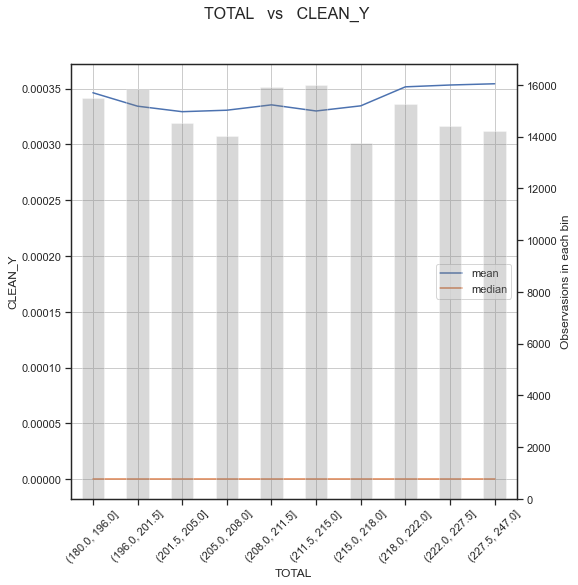

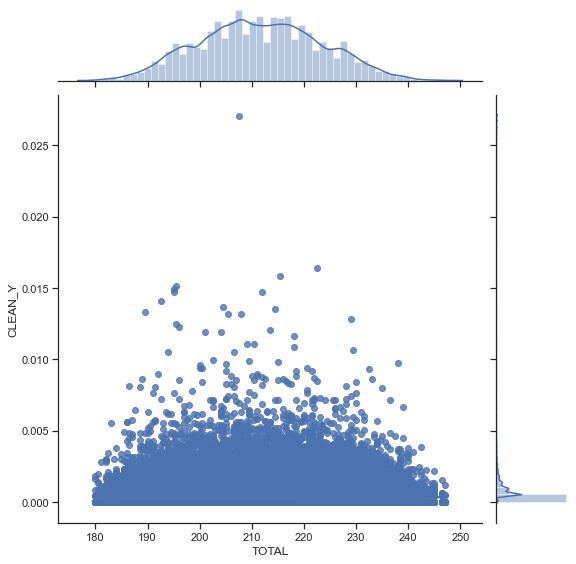

In [35]:
helpers.visualize_numeric_x_vs_y(boxscores, 'TOTAL', clean_y, figsize=(8, 8))

In [36]:
regressors.append('TOTAL')

### Weights
Lastly, I will add a column to weight each $Y$ value. I do not care about each occurance of the dependant variable equally; the $BPS$ of a player who blocks 1 shot in 180 seconds should not be weighted the same as the $BPS$ of a plyer who blocks 10 shots in 1800 seconds. 

The weight I will use will be a product of functions of the amount of seconds played in a game and the sum of seconds played by a player throughout that season:

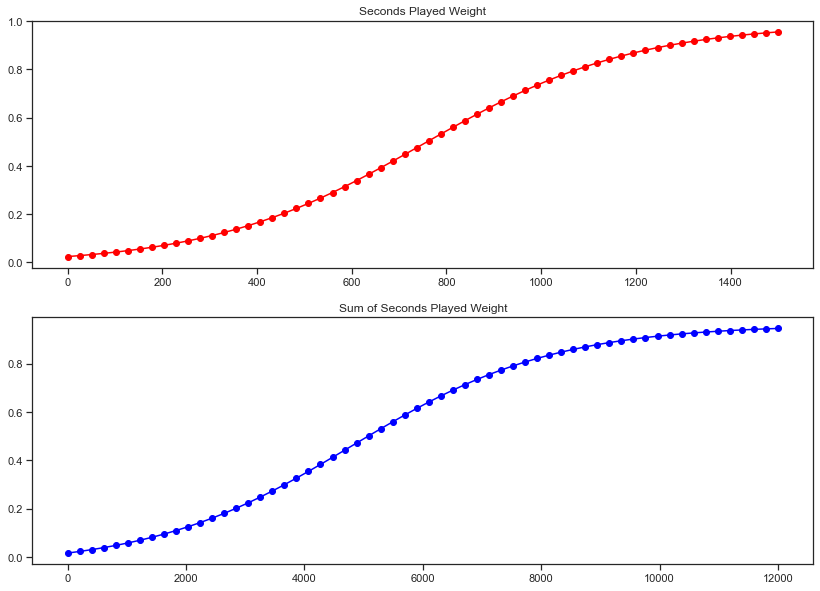

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

sp_weight_func = lambda x: 1/(1 + np.exp((-0.80*x + 600)/180)) - 0.01
sp_in_array = np.linspace(0, 60*25, 60)
sp_out_array = sp_weight_func(sp_in_array) 

tsp_weight_func = lambda x: 1/(1 + np.exp((-0.175*x + 840)/300)) - 0.04
tsp_in_array = np.linspace(0, 60*20*10, 60)
tsp_out_array = tsp_weight_func(tsp_in_array)

ax[0].title.set_text("Seconds Played Weight") 
ax[0].plot(sp_in_array, sp_out_array, color ='red', marker="o")

ax[1].title.set_text("Sum of Seconds Played Weight") 
ax[1].plot(tsp_in_array, tsp_out_array, color ='blue', marker="o") 
plt.show() 

In [38]:
boxscores = feature_creation.expanding_sum(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='SUM_SP'
)

w = 'WEIGHT'
boxscores[w] = boxscores['SECONDSPLAYED'].apply(sp_weight_func) * boxscores['SUM_SP'].apply(tsp_weight_func)

Some features we created to track historical performances mean less if the player has played less games/ minutes. To tell the non-linear models how much the player has played, I will create 2 regressors: number of games played ($COUNT\_GP$) and average seconds played ($AVG\_SP$)

In [39]:
boxscores['GP'] = 1
boxscores = feature_creation.expanding_sum(df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='GP', new_col_name='COUNT_GP')
regressors.append('COUNT_GP')


regressors.append('AVG_SP')

# Preprocessing
Now that I have created all the features I found to be indicative of our dependant variable, I will prepare the data to be suitable for a predictive model.

The first thing I will do is handle missing data.

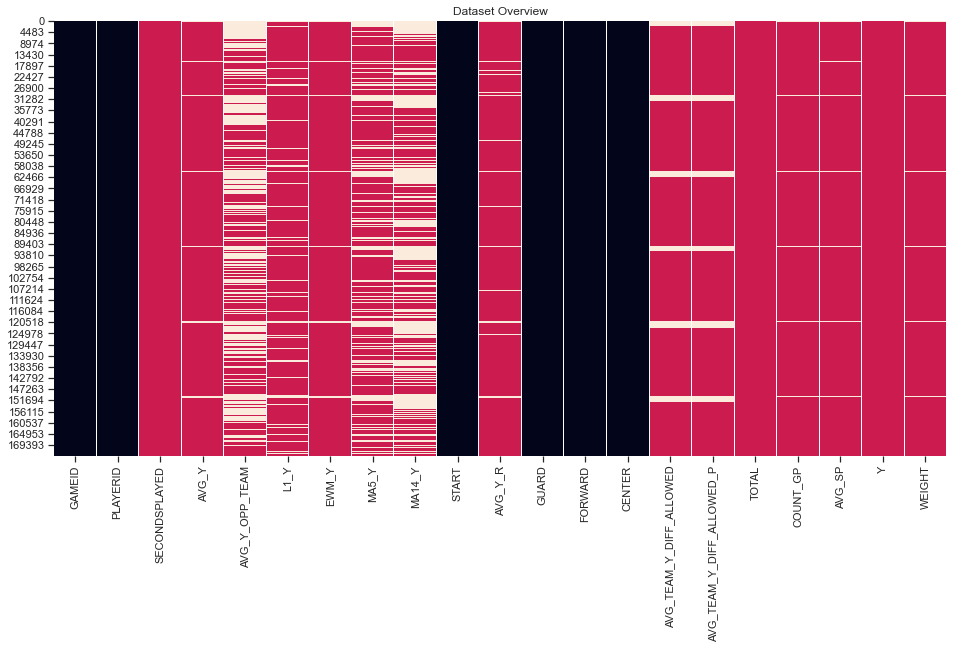

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 60.714


In [40]:
feature_matrix = boxscores[['GAMEID', 'PLAYERID', 'SECONDSPLAYED'] + regressors + [y] + [w]]

#drop games in which players played a minute or less
feature_matrix = feature_matrix.loc[feature_matrix['SECONDSPLAYED'] > 60]

helpers.visualize_dataframe(feature_matrix)

In [41]:
feature_matrix['AVG_Y_OPP_TEAM'] = feature_matrix['AVG_Y_OPP_TEAM'].fillna(feature_matrix['AVG_Y'])

feature_matrix['L1_Y'] = feature_matrix['L1_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['EWM_Y'] = feature_matrix['EWM_Y'].fillna(feature_matrix['AVG_Y'])

feature_matrix['MA5_Y'] = feature_matrix['MA5_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['MA14_Y'] = feature_matrix['MA14_Y'].fillna(feature_matrix['MA5_Y'])

feature_matrix['AVG_Y_R'] = feature_matrix['AVG_Y_R'].fillna(feature_matrix['AVG_Y'])

feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED'].fillna(0)
feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'].fillna(0)

feature_matrix['TOTAL'] = feature_matrix['TOTAL'].fillna(200)

feature_matrix['COUNT_GP'] = feature_matrix['COUNT_GP'].fillna(0)

# we can predict Y for a player as long as AVG_Y is not nan
feature_matrix = feature_matrix.dropna(subset=['AVG_Y'])

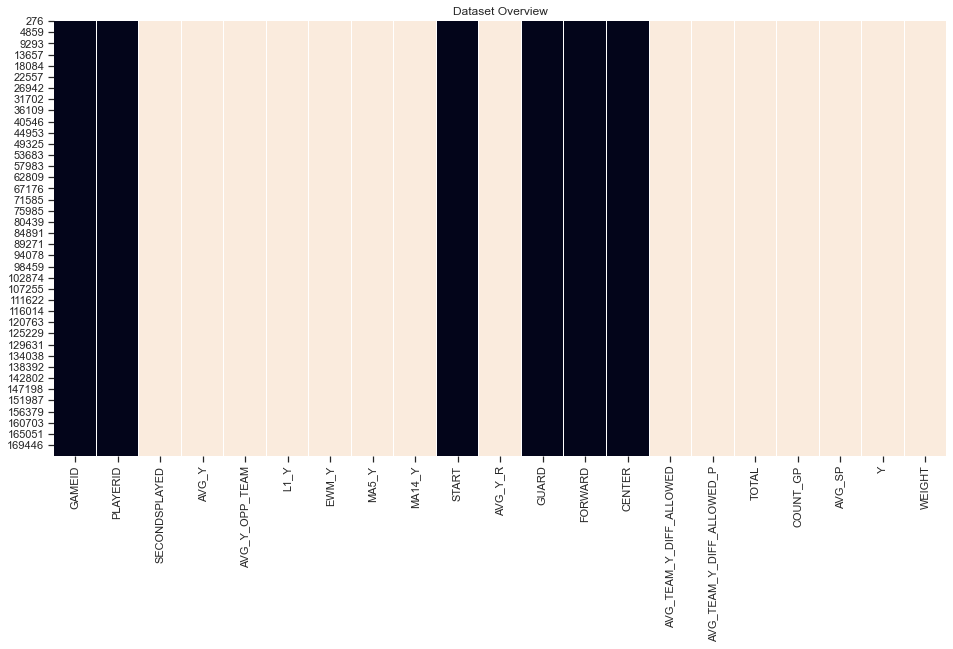

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [42]:
helpers.visualize_dataframe(feature_matrix)

# Model/Feature Selection
Finally, it's time to build the model. I will first iterate through various model types. Within each model iteration, I will isolate the important features. I will also try predicting the log transform of the dependant variable, and scaling the numeric columns, and pick whatever (Model, Feature Subset, \[Log Transform, No Transform\], \[Scale, No Scale\]) combination yeilds the lowest average MSE after 5-fold cross validation.

In [43]:
linear_models = [
    linear_model.LinearRegression()
#     linear_model.Ridge(),
#     linear_model.ElasticNet()
]

neighbor_models = [
#     neighbors.KNeighborsRegressor()
]

boosted_models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

neural_networks = [
    neural_network.MLPRegressor(max_iter=10000, early_stopping=True, random_state=42)
]

models = linear_models + neighbor_models + boosted_models + neural_networks

transformers = [
    {
        'Function': lambda x: x,
        'Inverse Function': lambda x: x,
        'Name': 'None'
    },
    {
        'Function': lambda x: np.log(x + 1),
        'Inverse Function': lambda x: np.exp(x) - 1,
        'Name': 'Log'
    }
]

numeric_regressors = list(set(regressors) - set(categorical_regressors))
numeric_columns = numeric_regressors + [y]

min_score = float('inf')
best_model = None
for model in models:
    for transformer in transformers:
        for scale in [False, True]:
            
            # transform numeric columns
            temp_feature_matrix = feature_matrix.copy()
            temp_feature_matrix[numeric_columns] = temp_feature_matrix[numeric_columns].apply(
                transformer['Function'], axis=1
            )
            
            # scale numeric features
            if scale:
                x_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                temp_feature_matrix[numeric_regressors] = x_scaler.fit_transform(temp_feature_matrix[numeric_regressors])
                
                y_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                temp_feature_matrix[[y]] = y_scaler.fit_transform(temp_feature_matrix[[y]])

            # feature selection
            X = temp_feature_matrix[regressors]
            Y = temp_feature_matrix[y]
            W = temp_feature_matrix[w]

            if model in (neighbor_models + neural_networks):
                selected_features = regressors.copy()
            else:
                model.fit(X, Y, sample_weight=W)
                
                # importance
                importance_selector = SelectFromModel(model, threshold='0.75*median')
                importance_selector = importance_selector.fit(X, Y, sample_weight=W)
                importance_support = importance_selector.get_support()
                
                # rank
                rank_selector = RFE(model)
                rank_selector = rank_selector.fit(X, Y)
                rank_support = rank_selector.ranking_
                median_rank = np.median(rank_support)
                
                selected_features = []
                for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
                    # select the feature if it's important, or has a low rank
                    if importance_flag or (rank <= median_rank):
                        selected_features.append(feature)

            X = temp_feature_matrix[selected_features].values
            Y = temp_feature_matrix[y].values
            W = temp_feature_matrix[w].values
            
            # cross validation
            scores = []
            cv = model_selection.KFold(n_splits=5, shuffle=True)
            for train, test in cv.split(X, Y, W):
                if model in (neural_networks + neighbor_models):
                    prediction = model.fit(X[train], Y[train]).predict(X[test])
                else:
                    prediction = model.fit(X[train], Y[train], sample_weight=W[train]).predict(X[test])
                true = Y[test]

                if scale:
                    prediction = y_scaler.inverse_transform(prediction.reshape(-1,1)).reshape(-1)
                    true = y_scaler.inverse_transform(true.reshape(-1,1)).reshape(-1)

                prediction = transformer['Inverse Function'](prediction)
                true = transformer['Inverse Function'](true)
                
                scores.append(metrics.mean_absolute_error(prediction, true, sample_weight=W[test]))

            mean_score = np.mean(scores)
            print('\nModel:', model)
            print('Transformer:', transformer['Name'])
            print('Scale:', scale)
            print('Selected Features:', selected_features)
            print('Mean MAE:', mean_score)
            if mean_score < min_score:
                min_score = mean_score
                best_model = (model, transformer['Name'], scale, selected_features)
print()
print(best_model, min_score)


Model: LinearRegression()
Transformer: None
Scale: False
Selected Features: ['AVG_Y', 'L1_Y', 'EWM_Y', 'MA5_Y', 'MA14_Y', 'AVG_Y_R', 'GUARD', 'CENTER', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P']
Mean MAE: 0.0003619301554170926

Model: LinearRegression()
Transformer: None
Scale: True
Selected Features: ['AVG_Y', 'MA5_Y', 'MA14_Y', 'AVG_Y_R', 'GUARD', 'FORWARD', 'CENTER', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P']
Mean MAE: 0.00036191063022205874

Model: LinearRegression()
Transformer: Log
Scale: False
Selected Features: ['AVG_Y', 'L1_Y', 'EWM_Y', 'MA5_Y', 'MA14_Y', 'AVG_Y_R', 'GUARD', 'FORWARD', 'CENTER', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P']
Mean MAE: 0.00036191819855144094

Model: LinearRegression()
Transformer: Log
Scale: True
Selected Features: ['AVG_Y', 'MA5_Y', 'MA14_Y', 'AVG_Y_R', 'GUARD', 'FORWARD', 'CENTER', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P']
Mean MAE: 0.0003618766649813203

Model: XGBRegressor(base_score=0.5, bo

The best model is a Catboost model with no log transformations or scaling.

# Parameter Tuning
Now, I will use Grid Search Cross Validation to find the CatBoostRegressor paramters that yeild the lowest average MSE on the test set.

In [44]:
selected_features = ['AVG_Y', 'AVG_Y_OPP_TEAM', 'L1_Y', 'EWM_Y', 'MA5_Y', 'MA14_Y', 'AVG_Y_R',
                     'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TOTAL', 'COUNT_GP', 'AVG_SP']
# selected_features = best_model[3]
X = feature_matrix[selected_features]
Y = feature_matrix[y]
W = feature_matrix[w]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.25, random_state=1)

In [45]:
model = CatBoostRegressor()

model_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'num_boost_round': [5000],
    'eval_metric': ['MAE']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": (X_test, y_test),
    'sample_weight': w_train
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

0:	learn: 0.0004275	test: 0.0004580	best: 0.0004580 (0)	total: 8.5ms	remaining: 42.5s
1:	learn: 0.0004198	test: 0.0004514	best: 0.0004514 (1)	total: 15.6ms	remaining: 38.9s
2:	learn: 0.0004131	test: 0.0004456	best: 0.0004456 (2)	total: 22.2ms	remaining: 36.9s
3:	learn: 0.0004074	test: 0.0004408	best: 0.0004408 (3)	total: 28.5ms	remaining: 35.6s
4:	learn: 0.0004025	test: 0.0004366	best: 0.0004366 (4)	total: 35.1ms	remaining: 35s
5:	learn: 0.0003981	test: 0.0004326	best: 0.0004326 (5)	total: 41.3ms	remaining: 34.3s
6:	learn: 0.0003942	test: 0.0004291	best: 0.0004291 (6)	total: 47.6ms	remaining: 33.9s
7:	learn: 0.0003909	test: 0.0004263	best: 0.0004263 (7)	total: 53.9ms	remaining: 33.7s
8:	learn: 0.0003879	test: 0.0004236	best: 0.0004236 (8)	total: 60.2ms	remaining: 33.4s
9:	learn: 0.0003854	test: 0.0004215	best: 0.0004215 (9)	total: 66.7ms	remaining: 33.3s
10:	learn: 0.0003830	test: 0.0004193	best: 0.0004193 (10)	total: 73.2ms	remaining: 33.2s
11:	learn: 0.0003811	test: 0.0004175	best: 0

94:	learn: 0.0003618	test: 0.0004025	best: 0.0004023 (83)	total: 598ms	remaining: 30.9s
95:	learn: 0.0003618	test: 0.0004025	best: 0.0004023 (83)	total: 605ms	remaining: 30.9s
96:	learn: 0.0003618	test: 0.0004025	best: 0.0004023 (83)	total: 611ms	remaining: 30.9s
97:	learn: 0.0003618	test: 0.0004025	best: 0.0004023 (83)	total: 617ms	remaining: 30.9s
98:	learn: 0.0003618	test: 0.0004025	best: 0.0004023 (83)	total: 623ms	remaining: 30.9s
99:	learn: 0.0003617	test: 0.0004026	best: 0.0004023 (83)	total: 629ms	remaining: 30.8s
100:	learn: 0.0003617	test: 0.0004026	best: 0.0004023 (83)	total: 635ms	remaining: 30.8s
101:	learn: 0.0003617	test: 0.0004026	best: 0.0004023 (83)	total: 642ms	remaining: 30.8s
102:	learn: 0.0003617	test: 0.0004026	best: 0.0004023 (83)	total: 648ms	remaining: 30.8s
103:	learn: 0.0003616	test: 0.0004026	best: 0.0004023 (83)	total: 654ms	remaining: 30.8s
104:	learn: 0.0003616	test: 0.0004026	best: 0.0004023 (83)	total: 660ms	remaining: 30.8s
105:	learn: 0.0003616	test:

# Evaluation
Lastly, I will evaluate the final model.

In [46]:
best_params = grid.best_params_
model = CatBoostRegressor(**best_params)

weighted_eval_set = Pool(
    data=X_test,
    label=y_test,
    weight=w_test
)
fit_params['eval_set'] = weighted_eval_set

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

0:	learn: 0.0004275	test: 0.0004262	best: 0.0004262 (0)	total: 8.36ms	remaining: 41.8s
1:	learn: 0.0004198	test: 0.0004187	best: 0.0004187 (1)	total: 15.2ms	remaining: 38s
2:	learn: 0.0004131	test: 0.0004121	best: 0.0004121 (2)	total: 22.1ms	remaining: 36.8s
3:	learn: 0.0004074	test: 0.0004065	best: 0.0004065 (3)	total: 28.5ms	remaining: 35.6s
4:	learn: 0.0004025	test: 0.0004017	best: 0.0004017 (4)	total: 36.1ms	remaining: 36.1s
5:	learn: 0.0003981	test: 0.0003974	best: 0.0003974 (5)	total: 42.5ms	remaining: 35.4s
6:	learn: 0.0003942	test: 0.0003936	best: 0.0003936 (6)	total: 48.7ms	remaining: 34.8s
7:	learn: 0.0003909	test: 0.0003904	best: 0.0003904 (7)	total: 55.2ms	remaining: 34.4s
8:	learn: 0.0003879	test: 0.0003874	best: 0.0003874 (8)	total: 61.9ms	remaining: 34.3s
9:	learn: 0.0003854	test: 0.0003850	best: 0.0003850 (9)	total: 68.1ms	remaining: 34s
10:	learn: 0.0003830	test: 0.0003827	best: 0.0003827 (10)	total: 74.2ms	remaining: 33.7s
11:	learn: 0.0003811	test: 0.0003808	best: 0.

97:	learn: 0.0003618	test: 0.0003626	best: 0.0003625 (89)	total: 620ms	remaining: 31s
98:	learn: 0.0003618	test: 0.0003626	best: 0.0003625 (89)	total: 627ms	remaining: 31s
99:	learn: 0.0003617	test: 0.0003626	best: 0.0003625 (89)	total: 633ms	remaining: 31s
100:	learn: 0.0003617	test: 0.0003626	best: 0.0003625 (89)	total: 640ms	remaining: 31s
101:	learn: 0.0003617	test: 0.0003626	best: 0.0003625 (89)	total: 646ms	remaining: 31s
102:	learn: 0.0003617	test: 0.0003626	best: 0.0003625 (89)	total: 652ms	remaining: 31s
103:	learn: 0.0003616	test: 0.0003626	best: 0.0003625 (89)	total: 658ms	remaining: 31s
104:	learn: 0.0003616	test: 0.0003626	best: 0.0003625 (89)	total: 664ms	remaining: 31s
105:	learn: 0.0003616	test: 0.0003626	best: 0.0003625 (89)	total: 671ms	remaining: 31s
106:	learn: 0.0003616	test: 0.0003626	best: 0.0003625 (89)	total: 677ms	remaining: 30.9s
107:	learn: 0.0003616	test: 0.0003625	best: 0.0003625 (107)	total: 683ms	remaining: 30.9s
108:	learn: 0.0003616	test: 0.0003625	bes

First, I will visualize the feature importances.

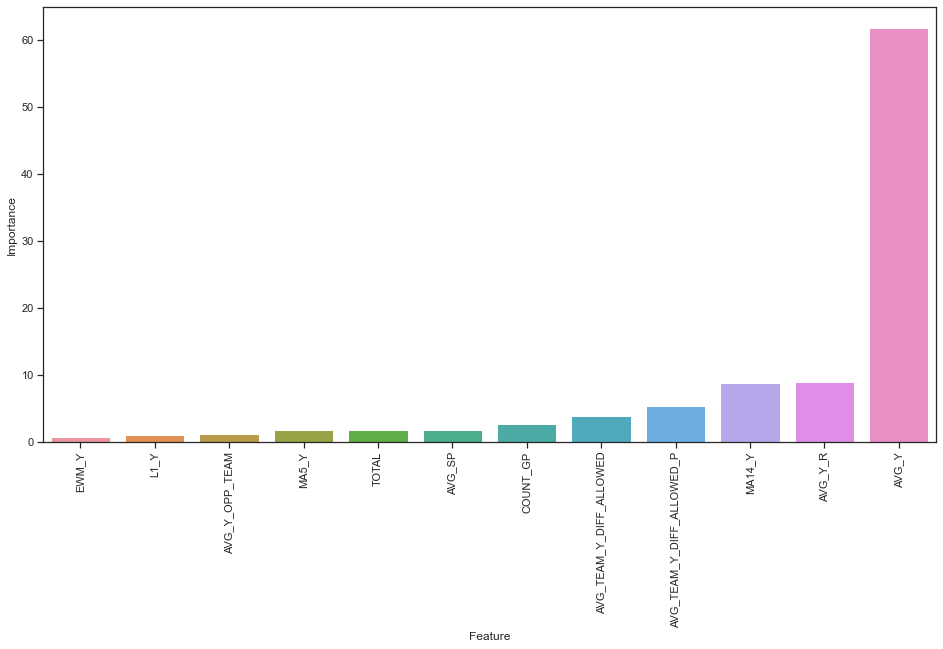

In [47]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

I will calculate a few metrics to evaluate the model's predictive power.

In [48]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_Y']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat, sample_weight=w_test), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg, sample_weight=w_test), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat, sample_weight=w_test), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg, sample_weight=w_test), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat, sample_weight=w_test)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg, sample_weight=w_test)), 6))

R2 (explained variance):
Model: 0.218
Baseline: 0.196

Mean Absolute Error (Σ|y-pred|/n):
Model: 0.000363
Baseline: 0.000359

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 0.000517
Baseline: 0.000524


Residual analysis:

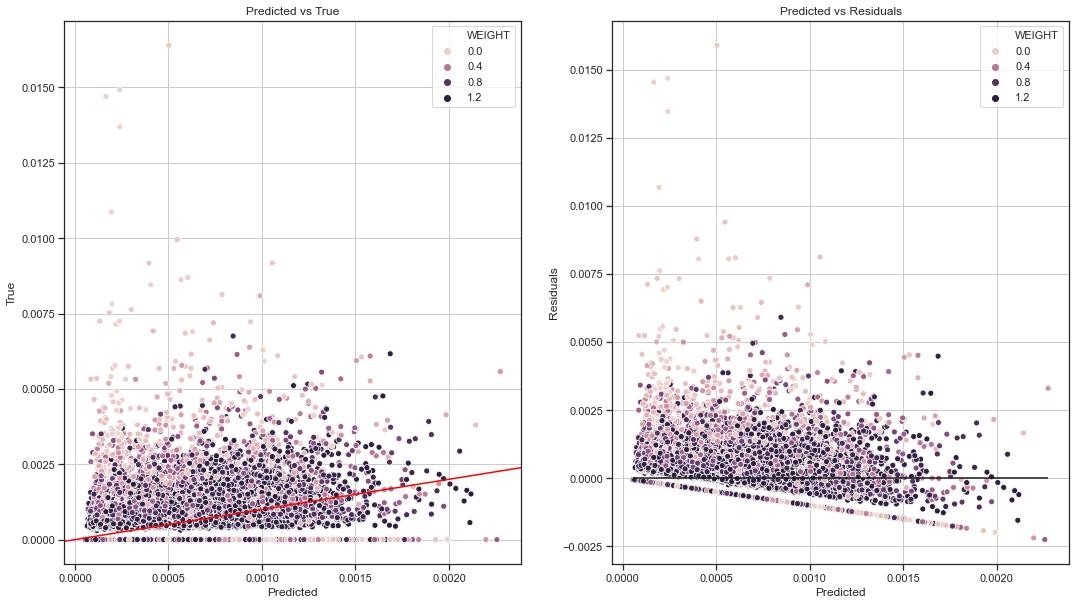

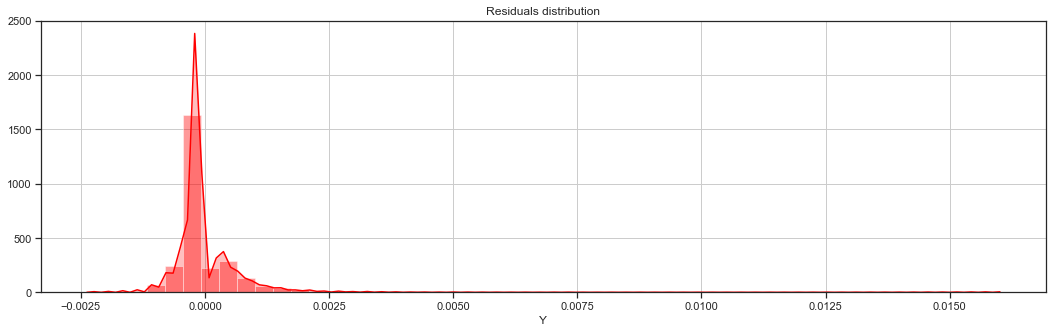

In [49]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, hue=w_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, hue=w_test, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [50]:
stat, p = shapiro(residuals)
print(stat, p)

0.7183912396430969 0.0


Residuals are normally distributed and not heteroskedastic.